# End to End Machine learning project 

#### Data used : 
California Housing Prices dataset from the StatLib repository

# Project Checklist 

- [x] Frame the problem and look at the bigger picture
- [x] Get the Data
- [ ] Explore the Data to gain insights 
- [ ] Prepare the data to better expose the underlying data pattersn to ML algos
- [ ] Explore many different models and shortlist the best ones 
- [ ] Fine tune the model and combine them into a solution
- [ ] Present the solution
- [ ] Launch, monitor and maintain the system
  

# Problem statement : 

Welcome to the Machine Learning Housing Corporation! Your first task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). I will call them “districts” for short.
Your model should learn from this data and be able to predict the median housing price in any district, given all the other metrics.

# Getting the Data


Rather than manually downloading and decompressing the data, it’s usually preferable to write a function that does it for you. 
This is useful in particular if the data changes regularly: 

    - You can write a small script that uses the function to fetch the latest data (or you can set up a scheduled job to do that automatically at regular intervals). 
    
    - Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines.

In [1]:
# Setting up the libraries 

# checking python version
import sys
assert sys.version_info >= (3, 7)

#checking scikit-learn version
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [2]:
# script to get and load the data 
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()


In [3]:
# Quick look at the data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# description of the data 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. Need to take care of this later.

In [5]:
# what categories exist and how many districts belong to each category by using the value_counts() method for ocean proxomity column:

housing['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# Decribe method shows a summary of the numerical attributes

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


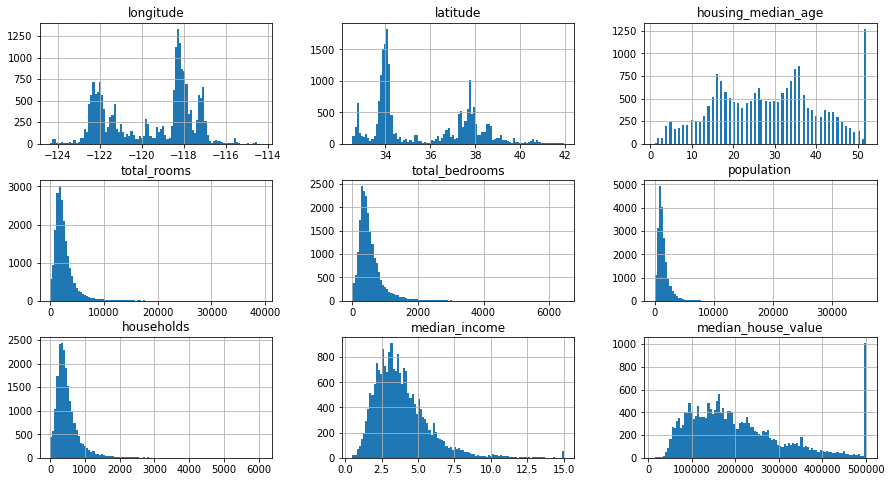

In [7]:
# A histogram shows the number of instances (on the vertical axis) 
# that have a given value range (on the horizontal axis). 
# You can either plot this one attribute at a time, or we can call the hist() method on the whole dataset 
# and it will plot a histogram for each *numerical attribute*

import matplotlib.pyplot as plt

housing.hist(bins=100, figsize=(15,8))
plt.show()

# Creating a test set 

In [8]:
import numpy as np

def shuffle_and_split_data(data , test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

# generating the test and train set 

train_set , test_set  = shuffle_and_split_data(housing, 0.2)

print(F"Length train set : {len(train_set)}")
print(F"Length test set : {len(test_set)}")


Length train set : 16512
Length test set : 4128


### Uniqueness of test set 

Well, this works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your machine learning algorithms) will get to see the whole dataset, which is what you want to avoid.

One solution is to save the test set on the first run and then load it in subsequent runs. Another option is to set the random number generator’s seed (e.g., with np.random.seed(42))6 before calling np.random.permutation() so that it always generates the same shuffled indices.

However, both these solutions will break the next time you fetch an updated dataset. 

To have a stable train/test split even after updating the dataset, a common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have unique and immutable identifiers). 

        For example, you could compute a hash of each instance’s identifier and put that instance in the test set if the hash is lower than or equal to 20% of the maximum hash value. 
        - This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. 
        - The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set.

In [9]:
# Implementation 


from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set] # "~" is a bitwise operator  NOT, which Inverts all the bits

# HOusing data doesnt have an identifier. 
# Use row index as id


housing_with_id = housing.reset_index()  # adds an `index` column
train_set , test_set = split_data_with_id_hash(housing_with_id, 0.2 , "index")


Scikit-Learn provides a few functions to split datasets into multiple subsets in various ways. 

The simplest function is train_test_split(), which does pretty much the same thing as the shuffle_and_split_data() function we defined earlier, with a couple of additional features. 

    - First, there is a random_state parameter that allows you to set the random generator seed. 
    - Second, you can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels):


In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

You’ve chatted with some experts who told you that the median income is a very important attribute to predict median housing prices. 
You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. 

Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely (back in Figure 2-8): most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. 

It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough

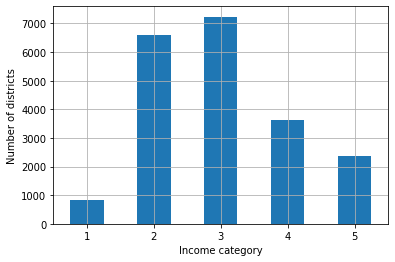

In [11]:
# pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5); 
# category 1 ranges from 0 to 1.5 (i.e., less than $15,000), 
# category 2 from 1.5 to 3, and so on

housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.,1.5,3.0, 4.5, 6.0, np.inf],
                               labels=[1, 2, 3, 4, 5]
                               )

# plotting the new category 

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

Stratified income category wise test data sampled so that each category is represented fairly

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])
    
# Using just the first split 

strat_train_set , strat_test_set = strat_splits[0]


In [13]:
# Pythonic implementation of the above code for single set 

strat_train_set, strat_test_set = train_test_split(
    housing,
    test_size=0.2,
    stratify=housing["income_cat"],
    random_state=42
)

In [14]:
# Checking if it worked by looking at the income category proportions in the test set:

strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [15]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)


3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

Both the test set and the train set has the same distribution of median income households 

**Question ?**
What to do if I want to stratify by 2 different columns ?   
**Answer :** 
read this  :  https://stackoverflow.com/questions/45516424/sklearn-train-test-split-on-pandas-stratify-by-multiple-columns

In [16]:
# Testing tratified sampling with full data 

def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall %": income_cat_proportions(housing),
    "Stratified %": income_cat_proportions(strat_test_set),
    "Random %": income_cat_proportions(test_set),
}).sort_index()
compare_props.index.name = "Income Category"

compare_props["Strat. Error %"] = (compare_props["Stratified %"] /
                                   compare_props["Overall %"] - 1)

compare_props["Rand. Error %"] = (compare_props["Random %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)



,Overall %,Stratified %,Random %,Strat. Error %,Rand. Error %
Income Category,,,,,
1,3.98,4.00,4.24,0.36,6.45
2,31.88,31.88,30.74,-0.02,-3.59
3,35.06,35.05,34.52,-0.01,-1.53
4,17.63,17.64,18.41,0.03,4.42
5,11.44,11.43,12.09,-0.08,5.63


In [17]:
# Dropping the income_cat colums as it served its purpose. 

for set_ in (strat_train_set, strat_test_set) : 
    set_.drop("income_cat", axis=1, inplace=True)

# Exploring and Visualizing the Data

If Training Set is large, take a sample and do EDA on that to save compute time and easier manipulations   
Create a copy of the data since train set would be transformed 

In [18]:
# Copying the data

housing = strat_train_set.copy()

### Visualizing Geographical Data

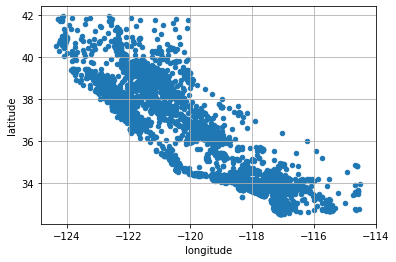

In [19]:
# Scatterplot of all districts 

housing.plot(kind="scatter", 
             x = "longitude",
             y = "latitude", 
             grid=True)
plt.show()

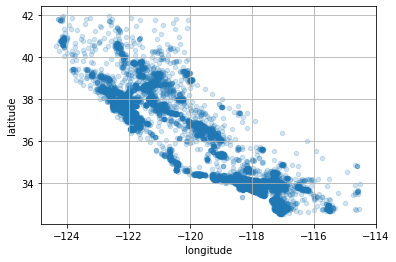

In [20]:
# setting density parameter 
housing.plot(kind="scatter",
             x="longitude",
             y="latitude",
             alpha=0.2,  # ‘alpha’ parameter is used for increasing the transparency of the markers
             grid=True)
plt.show()


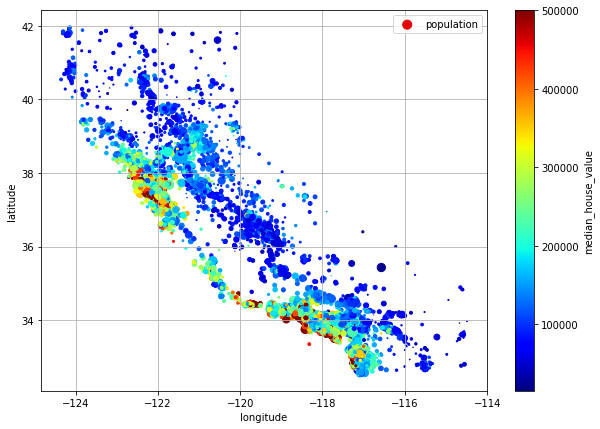

In [21]:
# look at the housing prices . 
# The radius of each circle represents the district’s population (option s), 
# and the color represents the price (option c). 
# Here you use a predefined color map (option cmap) called jet, 
# which ranges from blue (low values) to red (high prices)

housing.plot(kind="scatter",
             x="longitude",
             y="latitude",
             grid=True,
             s=housing["population"]/100,
             label="population",
             c="median_house_value",
             cmap="jet",
             colorbar=True,
             legend=True,
             sharex=False,
             figsize=(10,7)
             )
plt.show()


In [22]:
# Code to save image
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


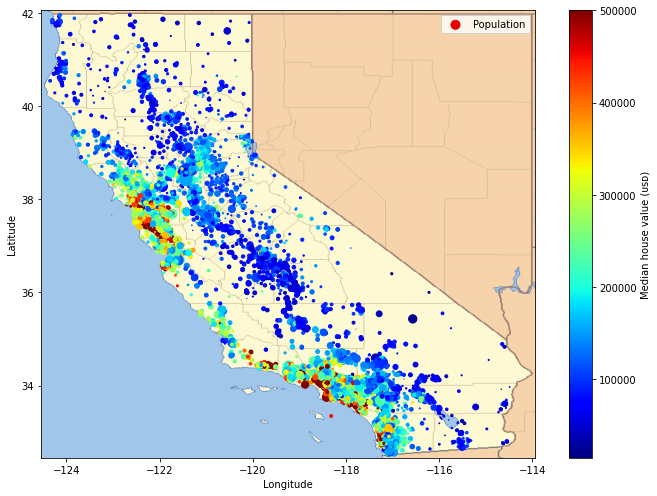

In [23]:
# Same visual on a map of California 

# Download the California image
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
filename = "california.png"
if not (IMAGES_PATH / filename).is_file():
    homl3_root = "https://github.com/ageron/handson-ml3/raw/main/"
    url = homl3_root + "images/end_to_end_project/" + filename
    print("Downloading", filename)
    urllib.request.urlretrieve(url, IMAGES_PATH / filename)

housing_renamed = housing.rename(columns={
    "latitude": "Latitude", "longitude": "Longitude",
    "population": "Population",
    "median_house_value": "Median house value (ᴜsᴅ)"})
housing_renamed.plot(
    kind="scatter", x="Longitude", y="Latitude",
    s=housing_renamed["Population"] / 100, label="Population",
    c="Median house value (ᴜsᴅ)", cmap="jet", colorbar=True,
    legend=True, sharex=False, figsize=(10, 7))

california_img = plt.imread(IMAGES_PATH / filename)
axis = -124.55, -113.95, 32.45, 42.05
plt.axis(axis)
plt.imshow(california_img, extent=axis)

save_fig("california_housing_prices_plot")
plt.show()


### Looking for Correlation

We can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the corr() method:

In [24]:
corr_matrix = housing.corr()

# how much each attribute correlates with the median house value:

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

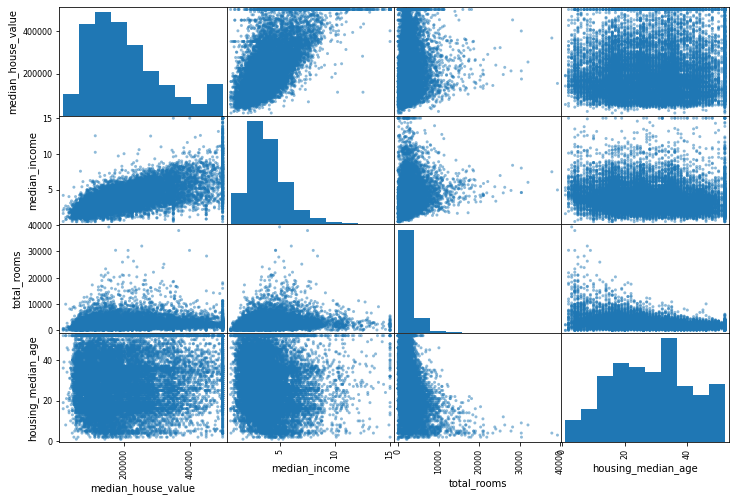

In [25]:
# Scatter Matrix 
# plots the numerical attributs against every other numerical attributes 
# and a histogram of numerical attributes on the main diagonal 

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

It seems like the most promising attribute to predict the median house value is the median income.   
so we zoom in on their scatterplot

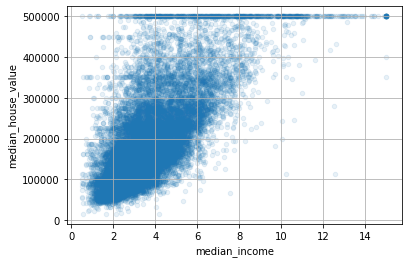

In [26]:
# Zoom in on median_income vs median_house_value scatterplot 
#‘alpha’ parameter is used for increasing the transparency of the markers
housing.plot(kind="scatter",
             x = "median_income",
             y = "median_house_value",
             alpha=0.1,
             grid=True)
plt.show()

In [27]:
# Creating New attributes 

housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

# and generating coorelatinon Matrix again 

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

The new bedrooms_ratio attribute is much more correlated with the median house value than the total number of rooms or bedrooms. 

Apparently houses with a lower bedroom/room ratio tend to be more expensive. 

The number of rooms per household is also more informative than the total number of rooms in a district— obviously the larger the houses, the more expensive they are.

# Preparing the Data for Machine Learning Algorithms

Instead of doing this manually, you should write functions for this purpose, for several good reasons:  
•   This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).  
•   You will gradually build a library of transformation functions that you can reuse in future projects.  
•   You can use these functions in your live system to transform the new data before feeding it to your algorithms.  
•   This will make it possible for you to easily try various transformations and see which combination of transformations works best.  

Let's revert to the original training set and separate the target (note that `strat_train_set.drop()` creates a copy of `strat_train_set` without the column, it doesn't actually modify `strat_train_set` itself, unless you pass `inplace=True`):

In [28]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"]

In [29]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,538.949094,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,423.862079,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,645.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


## Cleaning the data


In the book 3 options are listed to handle the NaN values:

```python
housing.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

housing.drop("total_bedrooms", axis=1)       # option 2

median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

For each option, we'll create a copy of `housing` and work on that copy to avoid breaking `housing`. We'll also show the output of each option, but filtering on the rows that originally contained a NaN value.

In [30]:
# calculating the index of rows which have a null value 
null_rows_idx = housing.isnull().any(axis=1)
housing.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,NaN,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,NaN,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,NaN,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,NaN,375.0,183.0,9.8020,<1H OCEAN


In [31]:
housing_option1 = housing.copy()

housing_option1.dropna(subset=["total_bedrooms"], inplace=True)  # option 1

# after the above code, the below code shoudl result in an empty dataframe

housing_option1.loc[null_rows_idx].head()



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [32]:
# Dropping the attribute itself 

housing_option2 = housing.copy()

housing_option2.drop("total_bedrooms", axis=1, inplace=True)  # option 2

#After dropping the attribute, the below code should show the OG DF without the attribute with values NaN
housing_option2.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,375.0,183.0,9.8020,<1H OCEAN


In [33]:
# OPtion 3 
# Imputation 

housing_option3 = housing.copy()

median = housing["total_bedrooms"].median()
housing_option3["total_bedrooms"].fillna(median, inplace=True)  # option 3
# Filled the NaN values with the median of the whole column 
# below should result in a DF with NaN replaced by the median value 
housing_option3.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962,INLAND
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115,<1H OCEAN
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917,<1H OCEAN
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033,<1H OCEAN
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020,<1H OCEAN


## Imputations using Scikit-learn

In [34]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")


Separating out the numerical attributes to use the `"median"` strategy (as it cannot be calculated on text attributes like `ocean_proximity`):

In [35]:
housing_num = housing.select_dtypes(include=[np.number])

In [36]:
# fitting the imputer instance with the traininf data 

imputer.fit(housing_num)

SimpleImputer(strategy='median')

The imputer has simply computed the median of each attribute and stored the result in its statistics_ instance variable. Only the total_bedrooms attribute had missing values, but you cannot be sure that there won’t be any missing values in new data after the system goes live, so it is safer to apply the imputer to all the numerical attributes:

In [37]:
imputer.statistics_


array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

This is the same as manually computing the median of each attribute:

In [38]:
housing_num.median().values


array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

Using this “trained” imputer to transform the training set by replacing missing values with the learned medians:

In [39]:
X = imputer.transform(housing_num)


Missing values can also be replaced with 

    - the mean value (strategy="mean"),
    - or with the most frequent value (strategy="most_frequent"), or 
    - with a constant value (strategy="constant", fill_value=...) 

The last two strategies support non- numerical data.

Scikit-Learn transformers output NumPy arrays (or sometimes SciPy sparse matri‐ ces) even when they are fed Pandas DataFrames as input. 

So, the output of imputer.transform(housing_num) is a NumPy array: X has neither column names nor index.

In [40]:
imputer.feature_names_in_


array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype=object)

In [41]:
# wrap X in a DataFrame and recover the column names and index from housing_num:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)


In [42]:
# Above code is not required in newer version of Sklearn
# Use this code to set output to a pandas array
#from sklearn import set_config
#
# set_config(transform_output="pandas")  # scikit-learn >= 1.2
# sklearn.__version__


In [43]:
# Transformed columns which were NaN previously 

housing_tr.loc[null_rows_idx].head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14452,-120.67,40.50,15.0,5343.0,434.0,2503.0,902.0,3.5962
18217,-117.96,34.03,35.0,2093.0,434.0,1755.0,403.0,3.4115
11889,-118.05,34.04,33.0,1348.0,434.0,1098.0,257.0,4.2917
20325,-118.88,34.17,15.0,4260.0,434.0,1701.0,669.0,5.1033
14360,-117.87,33.62,8.0,1266.0,434.0,375.0,183.0,9.8020


In [44]:
imputer.strategy

'median'

Dropping outliers 

In [45]:
sklearn.__version__

'1.2.2'

In [46]:
# Would run in newer versions of Sklearn, ie >.1.2.2

from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)


In [47]:
# 1 for inliers, -1 for outliers 
outlier_pred


array([-1,  1,  1, ...,  1,  1,  1])

In [48]:
unique, frequency = np.unique(outlier_pred,return_counts=True)
print(F"Outliers (-1): {frequency[0]} \nInliers (1) :{frequency[1]}")


Outliers (-1): 2064 
Inliers (1) :14448


 to drop outliers, you would run the following code:

In [49]:
# Not dropping the outliers rn
#housing = housing.iloc[outlier_pred == 1]
#housing_labels = housing_labels.iloc[outlier_pred == 1]


In [50]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,538.949094,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,423.862079,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,645.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100


## Handling Text and Categorical Attributes

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [51]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(8)


,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY


Machine learning algorithms prefer to work with numbers, so let’s convert these categories from text to numbers.

In [52]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # Fit and transform together 


In [53]:
housing_cat_encoded[:8]

array([[3.],
       [0.],
       [1.],
       [1.],
       [4.],
       [1.],
       [0.],
       [3.]])

In [54]:
# Ordinal encoder categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#### One-Hot encoding 

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values.   
This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, and “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1).   
To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is "<1H OCEAN" (and 0 otherwise), another attribute equal to 1 when the category is "INLAND" (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). 
The new attributes are sometimes called dummy attributes.

In [55]:
# OneHotEncoder class to convert categorical values into one-hot vectors
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat1hot = cat_encoder.fit_transform(housing_cat)


By default, the output of a OneHotEncoder is a SciPy sparse matrix, instead of a NumPy array:

In [56]:
housing_cat1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [57]:
print(housing_cat1hot)

  (0, 3)	1.0
  (1, 0)	1.0
  (2, 1)	1.0
  (3, 1)	1.0
  (4, 4)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 3)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 1)	1.0
  (14, 4)	1.0
  (15, 0)	1.0
  (16, 1)	1.0
  (17, 3)	1.0
  (18, 1)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 4)	1.0
  (22, 1)	1.0
  (23, 3)	1.0
  (24, 1)	1.0
  :	:
  (16487, 1)	1.0
  (16488, 0)	1.0
  (16489, 0)	1.0
  (16490, 3)	1.0
  (16491, 1)	1.0
  (16492, 4)	1.0
  (16493, 4)	1.0
  (16494, 1)	1.0
  (16495, 0)	1.0
  (16496, 1)	1.0
  (16497, 0)	1.0
  (16498, 0)	1.0
  (16499, 4)	1.0
  (16500, 0)	1.0
  (16501, 0)	1.0
  (16502, 0)	1.0
  (16503, 0)	1.0
  (16504, 0)	1.0
  (16505, 0)	1.0
  (16506, 1)	1.0
  (16507, 0)	1.0
  (16508, 1)	1.0
  (16509, 4)	1.0
  (16510, 0)	1.0
  (16511, 4)	1.0


You can use a sparse matrix mostly like a normal 2D array,12 but if you want to convert it to a (dense) NumPy array, just call the toarray() method:

In [58]:
housing_cat1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [59]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [60]:
# As with the OrdinalEncoder, you can get the list of categories using the encoder’s categories_ instance variable:

cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Using Pandas for 1 hot encoding

In [61]:
# Pandas has a function called get_dummies(), 
# which also converts each categorical feature into a one-hot representation, 
# with one binary feature per category:

df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
#df_test = pd.DataFrame({"ocean_proximity": ["Apple", "Bananans"]})
# above line wont work in cat_encoder instance which is trained on housing_cat

pd.get_dummies(df_test)


,ocean_proximity_INLAND,ocean_proximity_NEAR BAY
0,1,0
1,0,1


Advantage of OneHotEncoder over get_dummies :  
advantage of OneHotEncoder is that it remembers which categories it was trained on. This is very important because once your model is in production, it should be fed exactly the same features as during training: no more, no less.  

In [62]:
print(df_test)
cat_encoder.transform(df_test)

# our trained cat_encoder remembered the original categories it was trained on. 


  ocean_proximity
0          INLAND
1        NEAR BAY


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

if you feed get_dummies() a DataFrame containing an unknown category (e.g., "<2H OCEAN"), it will happily generate a column for it:

In [63]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)


,ocean_proximity_<2H OCEAN,ocean_proximity_ISLAND
0,1,0
1,0,1


But OneHotEncoder is smarter: it will detect the unknown category and raise an exception. If you prefer, you can set the handle_unknown hyperparameter to "ignore", in which case it will just represent the unknown category with zeros:

In [64]:
cat_encoder.handle_unknown = "ignore"
cat_encoder.transform(df_test_unknown)


array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

When you fit any Scikit-Learn estimator using a DataFrame, the estimator stores the column names in the feature_names_in_ attribute.

Scikit-Learn then ensures that any DataFrame fed to this estimator after that (e.g., to transform() or predict()) has the same column names

In [65]:
cat_encoder.feature_names_in_


array(['ocean_proximity'], dtype=object)

Transformers also provide a get_feature_names_out() method that you can use to build a DataFrame around the transformer’s output

In [66]:
cat_encoder.get_feature_names_out()


array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [67]:
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index
                         
                         )

In [68]:
df_output

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0


 ## Feature Scaling

#### min-max scaling ( Normalization )

Min-max scaling (many people call this normalization) is the simplest: for each attribute, the values are shifted and rescaled so that they end up ranging from 0 to 1. This is performed by subtracting the min value and dividing by the dif‐ ference between the min and the max. Scikit-Learn provides a transformer called MinMaxScaler for this. It has a feature_range hyperparameter that lets you change the range if, for some reason, you don’t want 0–1 (e.g., neural networks work best with zero-mean inputs, so a range of –1 to 1 is preferable).

In [69]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num) # housing_num = only numerical data from the og dataset

In [70]:
housing_num_min_max_scaled[:5]

array([[-0.60851927,  0.11702128,  1.        , -0.83117147, -0.64116605,
        -0.80701754, -0.61433638, -0.7794789 ],
       [ 0.21095335, -0.66170213,  0.52941176, -0.90014752, -0.88629409,
        -0.91866029, -0.86708979, -0.22929339],
       [-0.51926978,  0.23617021,  0.25490196, -0.94501246, -0.93042358,
        -0.93141946, -0.92458466, -0.73336919],
       [ 0.46855984, -0.74468085, -0.37254902, -0.78778168, -0.7262039 ,
        -0.77401546, -0.70916558, -0.75698266],
       [ 0.25760649, -0.74042553,  0.37254902, -0.77801516, -0.6102432 ,
        -0.76579561, -0.56281501, -0.58217128]])

#### Standardization

first it subtracts the mean value (so standardized values have a zero mean), then it divides the result by the standard deviation (so standard‐ ized values have a standard deviation equal to 1). Unlike min-max scaling, standardi‐ zation does not restrict values to a specific range. However, standardization is much less affected by outliers. For example, suppose a district has a median income equal to 100 (by mistake), instead of the usual 0–15. Min-max scaling to the 0–1 range would map this outlier down to 1 and it would crush all the other values down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization

In [71]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)


In [72]:
housing_num_std_scaled[:5]

array([[-1.42303652,  1.0136059 ,  1.86111875,  0.31191221,  1.35909429,
         0.13746004,  1.39481249, -0.93649149],
       [ 0.59639445, -0.702103  ,  0.90762971, -0.30861991, -0.43635598,
        -0.69377062, -0.37348471,  1.17194198],
       [-1.2030985 ,  1.27611874,  0.35142777, -0.71224036, -0.75958421,
        -0.78876841, -0.77572662, -0.75978881],
       [ 1.23121557, -0.88492444, -0.91989094,  0.70226169,  0.73623112,
         0.38317548,  0.73137454, -0.85028088],
       [ 0.71136206, -0.87554898,  0.58980003,  0.79012465,  1.58558998,
         0.44437597,  1.75526303, -0.18036472]])

#### Heavy Tail 

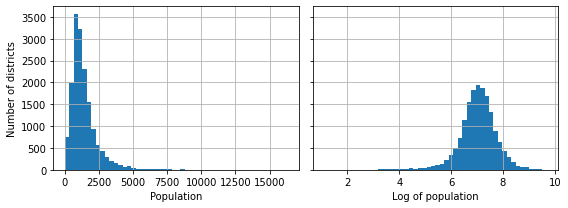

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
save_fig("long_tail_plot")
plt.show()


##### Bucketizing 

What if we replace each value with its percentile?  

**Bucketizing** the feature. This means chopping its distribution into roughly equal-sized buckets, and replacing each feature value with the index of the bucket it belongs to, much like we did to create the income_cat feature (although we only used it for stratified sampling). For example, *you could replace each value with its percentile*. Bucketizing with equal-sized buckets results in a feature with an almost uniform distribution, so there’s no need for further scaling, or you can just divide by the number of buckets to force the values to the 0–1 range.




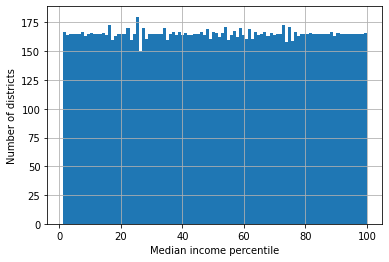

In [126]:
percentiles = [np.percentile(housing["median_income"], p) for p in range(1, 100)]

# Use cut when you need to segment and sort data values into bins. 
# This function is also useful for going from a continuous variable to a categorical variable. 
# For example, cut could convert ages to groups of age ranges. 
# Supports binning into an equal number of bins, or a pre-specified array of bins.
flattened_median_income = pd.cut(housing["median_income"],
                                 bins=[-np.inf] + percentiles + [np.inf], # adds -inf and inf at the bginning and end of percentile list
                                 labels=range(1, 100 + 1))
flattened_median_income.hist(bins=100)
plt.xlabel("Median income percentile")
plt.ylabel("Number of districts")
plt.show()
# Note: incomes below the 1st percentile are labeled 1, and incomes above the
# 99th percentile are labeled 100. This is why the distribution below ranges
# from 1 to 100 (not 0 to 100).


In [123]:
# checking how percentile works 
#temp = [(p,np.percentile([8,7,2,1,5,3,6,10,9,4],p)) for p in  range(10,101,10)]
temp = [(p,np.percentile([1,2,3,4,5,6,7,8,9,10],p)) for p in  range(10,101,10)]
# the line above should't change the percentile values 

In [124]:
for i,j in temp:
    print(F"Percentile :{i} Value :{j} ")

Percentile :10 Value :1.9 
Percentile :20 Value :2.8 
Percentile :30 Value :3.6999999999999997 
Percentile :40 Value :4.6 
Percentile :50 Value :5.5 
Percentile :60 Value :6.3999999999999995 
Percentile :70 Value :7.3 
Percentile :80 Value :8.2 
Percentile :90 Value :9.1 
Percentile :100 Value :10.0 


In [128]:
print(type(flattened_median_income))
flattened_median_income.head()

<class 'pandas.core.series.Series'>


13096    14
14973    90
3785     22
14689    18
20507    50
Name: median_income, dtype: category
Categories (100, int64): [1 < 2 < 3 < 4 ... 97 < 98 < 99 < 100]

In [129]:
housing["median_income"].head()

13096    2.0987
14973    6.0876
3785     2.4330
14689    2.2618
20507    3.5292
Name: median_income, dtype: float64

When a feature has a multimodal distribution (i.e., with two or more clear peaks, called modes), such as the *housing_median_age* feature, it can also be helpful to bucketize it, but this time treating the bucket IDs as categories, rather than as numerical values. This means that the bucket indices must be encoded, for example using a OneHotEncoder (so you usually don’t want to use too many buckets). ***This approach will allow the regression model to more easily learn different rules for different ranges of this feature value.*** For example, perhaps houses built around 35 years ago have a peculiar style that fell out of fashion, and therefore they’re cheaper than their age alone would suggest.

Another approach to transforming multimodal distributions is to add a feature for each of the modes (at least the main ones), representing the similarity between the housing median age and that particular mode. The similarity measure is typically computed using a radial basis function (RBF)—any function that depends only on the distance between the input value and a fixed point. The most commonly used RBF is the Gaussian RBF, whose output value decays exponentially as the input value moves away from the fixed point. For example, the Gaussian RBF similarity between the housing age x and 35 is given by the equation exp(–γ(x – 35)2). The hyperparameter γ (gamma) determines how quickly the similarity measure decays as x moves away from 35. Using Scikit-Learn’s rbf_kernel() function, you can create a new Gaussian RBF feature measuring the similarity between the housing median age and 35:

In [130]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)


Code below shows this new feature as a function of the housing median age (solid line). It also shows what the feature would look like if you used a smaller gamma value. As the chart shows, the new age similarity feature peaks at 35, right around the spike in the housing median age distribution: if this particular age group is well correlated with lower prices, there’s a good chance that this new feature will help.

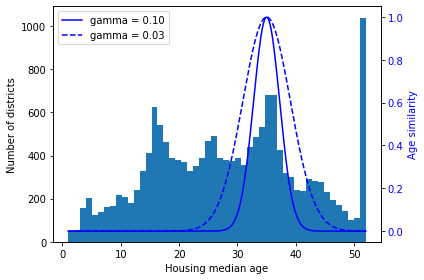

In [131]:
ages = np.linspace(housing["housing_median_age"].min(),
                   housing["housing_median_age"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(ages, [[35]], gamma=gamma1)
rbf2 = rbf_kernel(ages, [[35]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("Housing median age")
ax1.set_ylabel("Number of districts")
ax1.hist(housing["housing_median_age"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(ages, rbf1, color=color, label="gamma = 0.10")
ax2.plot(ages, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Age similarity", color=color)

plt.legend(loc="upper left")
save_fig("age_similarity_plot")
plt.show()


Reversing the Transformation of variables using inverse_transform 

In [132]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]],scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] # this is new data 

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [133]:
predictions

array([[131997.15275877],
       [299359.35844434],
       [146023.37185694],
       [138840.33653057],
       [192016.61557639]])

a simpler option is to use a TransformedTargetRegressor. We just need to construct it, giving it the regression model and the label transformer, then fit it on the training set, using the original unscaled labels. It will automatically use the transformer to scale the labels and train the regression model on the resulting scaled labels, just like we did previously. Then, when we want to make a prediction, it will call the regression model’s predict() method and use the scaler’s inverse_trans form() method to produce the prediction:

In [134]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)


In [135]:
predictions

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

## Custom Transformers

custom transformations, cleanup operations, or combining specific attributes

In [136]:
# Log transformation 
#  inverse_func argument is optional.
# It lets you specify an inverse transform function,
# e.g., if you plan to use your transformer in a TransformedTargetRegressor.

from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])


In [138]:
# custom RBF transformer 

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])



In [139]:
age_simil_35


array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

There’s no inverse function for the RBF kernel, since there are always two values at a given distance from a fixed point (except at distance 0). 

Also note that ***rbf_kernel() does not treat the features separately***. If you pass it an array with two features, it will measure the 2D distance (Euclidean) to measure similarity. For example, here’s how to add a feature that will measure the geographic similarity between each district and San Francisco:

In [141]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])


In [143]:
print(len(sf_simil))
sf_simil



16512


array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

Combining features

In [149]:
# a FunctionTransformer that computes the ratio between the input features 0 and 1:
ratio_transformer = FunctionTransformer(lambda X: X[:,[0]]/ X[:,[1]])
ratio_transformer.transform(np.array([[1.,2.],[3.,4.]]))


array([[0.5 ],
       [0.75]])

### Trainable Custom Transformer 

your transformer to be trainable, learning some parameters in the fit() method and using them later in the transform() method? For this, you need to write a custom class. Scikit-Learn relies on ***duck typing***, so this class does not have to inherit from any particular base class. All it needs is three methods: fit() (which must return self), transform(), and fit_transform().
You can get fit_transform() for free by simply adding TransformerMixin as a base class: the default implementation will just call fit() and then transform(). If you add BaseEstimator as a base class (and avoid using *args and **kwargs in your constructor), you will also get two extra methods: get_params() and set_params(). These will be useful for automatic hyperparameter tuning.

***Duck typing*** is a concept in programming languages that means an object’s suitability is determined by the presence of certain methods and properties, rather than by the type of the object itself. 

For example, in Python, you can use the len() function on any object that has a len() method, regardless of its class. This is different from static typing, where the type of an object is checked at compile time and determines what operations are allowed on it.

here’s a custom transformer that acts much like the StandardScaler:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
    
    def __init__(self, with_mean=True): # no args or kwargs
        self.with_mean = with_mean
        
    def fit(self, X, y=None): # y is required even though we don't use it 
        X = check_array(X) # checks that if X is an array with finite float values 
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        